In [1]:
import random
import string
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from einops import rearrange
from torch.utils.data import DataLoader
from tqdm import tqdm

import precip
import wandb
from precip.config import LOCAL_PRECIP_BOUNDARY_MASK
from precip.data.dataset import InfiniteSampler, SwedishPrecipitationDataset, npy_loader
from precip.models.conv_lstm.model import ConvLSTM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


@dataclass(frozen=True)
class ModelConfigUNet:
    model_name: str = "convlstm_full_prototype"
    batch_size: int = 2
    number_of_steps: int = 60
    training_size_per_step: int = 1_000
    validation_size_per_step: int = 300
    lr: float = 5.34e-03
    lr_scheduler_step: int = 3
    lr_scheduler_gamma: float = 0.85
    weight_decay: float = 1e-4
    
training_dataset = SwedishPrecipitationDataset(split="train", scale=True, apply_mask_to_zero=True, insert_channel_dimension=True)
validation_dataset = SwedishPrecipitationDataset(split="val", scale=True, apply_mask_to_zero=True, insert_channel_dimension=True)

training_sampler = InfiniteSampler(training_dataset, shuffle=True)
validation_sampler = InfiniteSampler(validation_dataset, shuffle=True)

dataloader = DataLoader(
    training_dataset, sampler=training_sampler, batch_size=2, num_workers=12
)
val_dataloader = DataLoader(
    validation_dataset, sampler=validation_sampler, batch_size=2, num_workers=12
)
train_dataiter, val_dataiter = iter(dataloader), iter(val_dataloader)

In [194]:
class DownConvLSTM(nn.Module):
    def __init__(
        self, in_channels, hidden_channels, out_channels, kernel_size, stride, padding
    ) -> None:
        super().__init__()

        self.conv = nn.Conv2d(in_channels, hidden_channels, kernel_size, stride, padding)
        self.conv_lstm = ConvLSTM(hidden_channels, out_channels, kernel_size, num_layers=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, t, c, h, w = x.size()
        x = rearrange(x, "b t c h w -> (b t) c h w ")
        x = rearrange(self.conv(x), "(b t) c h w -> b t c h w", b=b, t=t)
        x, _ = self.conv_lstm(x)
        return x


class UpBiLinearConvLSTM(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        upsample_size: Optional[Tuple[int, int]] = None,
    ) -> None:
        super().__init__()

        self.conv_lstm = ConvLSTM(in_channels, out_channels, kernel_size, 1)
        if upsample_size is not None:
            self.up_scale = nn.UpsamplingBilinear2d(size=upsample_size)
        else:
            self.up_scale = nn.UpsamplingBilinear2d(scale_factor=2.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, _ = self.conv_lstm(x)
        b, t, c, h, w = x.size()
        x = rearrange(
            self.up_scale(rearrange(x, "b t c h w -> (b t) c h w")),
            "(b t) c h w -> b t c h w",
            b=b,
            t=t,
        )

        return x


class UNetConvLSTM(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.d1 = DownConvLSTM(1, 8, 64, 4, 2, 1)
        self.d2 = DownConvLSTM(64, 128, 128, 3, 2, 1)
        self.d3 = DownConvLSTM(128, 256, 256, 3, 2, 1)

        self.u3 = UpBiLinearConvLSTM(256, 128, 3)
        self.u2 = UpBiLinearConvLSTM(256, 32, 3)
        self.u1 = UpBiLinearConvLSTM(64, 8, 1)
        self.out = nn.Sequential(
            nn.Conv2d(8, 1, 1, 1)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x
        
        
def concat(x: torch.Tensor, y: torch.Tensor, dim: int) -> torch.Tensor:
    diff_X = y.size(3) - x.size(3)
    diff_Y = y.size(4) - x.size(4)
    x = F.pad(x,[diff_Y //2, diff_Y - diff_Y //2, diff_X //2, diff_X- diff_X //2])
    return torch.cat([x, y], dim=dim)
    

In [10]:
batch_X, batch_y = next(train_dataiter)

In [5]:
batch_X.shape

torch.Size([2, 4, 1, 881, 458])

In [165]:
model = UNetConvLSTM()

In [166]:
z1 = model.d1(batch_X)
z1.shape

torch.Size([2, 4, 64, 440, 229])

In [167]:
z2 = model.d2(z1)
z2.shape

torch.Size([2, 4, 128, 220, 115])

In [168]:
z3 = model.d3(z2)
z3.shape

torch.Size([2, 4, 256, 110, 58])

In [170]:
w3 = model.u3(z3)

In [171]:
w3.shape

torch.Size([2, 4, 128, 220, 116])

In [197]:
w2 = model.u2(concat(w3, z2, dim=2))

In [199]:
w2.shape

torch.Size([2, 4, 32, 440, 230])

In [200]:
z1.shape

torch.Size([2, 4, 64, 440, 229])

In [198]:
w1 = model.u1(concat(w2, z1, dim=2))

RuntimeError: Given groups=1, weight of size [32, 72, 1, 1], expected input[2, 104, 440, 229] to have 72 channels, but got 104 channels instead

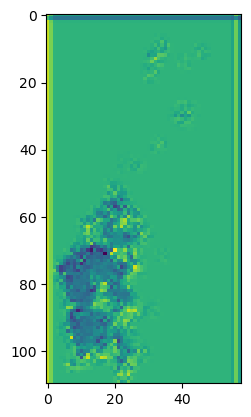

In [169]:
import matplotlib.pyplot as plt

plt.imshow(z3[0, 0, 11].detach().numpy())

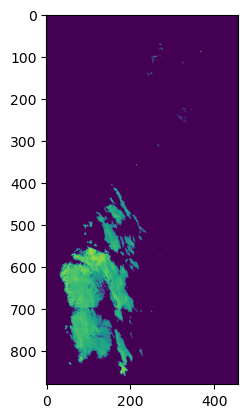

In [155]:
batch_X, batch_y = next(train_dataiter)

plt.imshow(batch_X[0, 0, 0].detach().numpy())